In [5]:
import matplotlib
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Liberation Serif'
# plt.rcParams['font.family'] = 'Liberation Serif Bold'
from matplotlib.font_manager import FontProperties
print("Current font:", FontProperties().get_name())

Current font: Liberation Serif


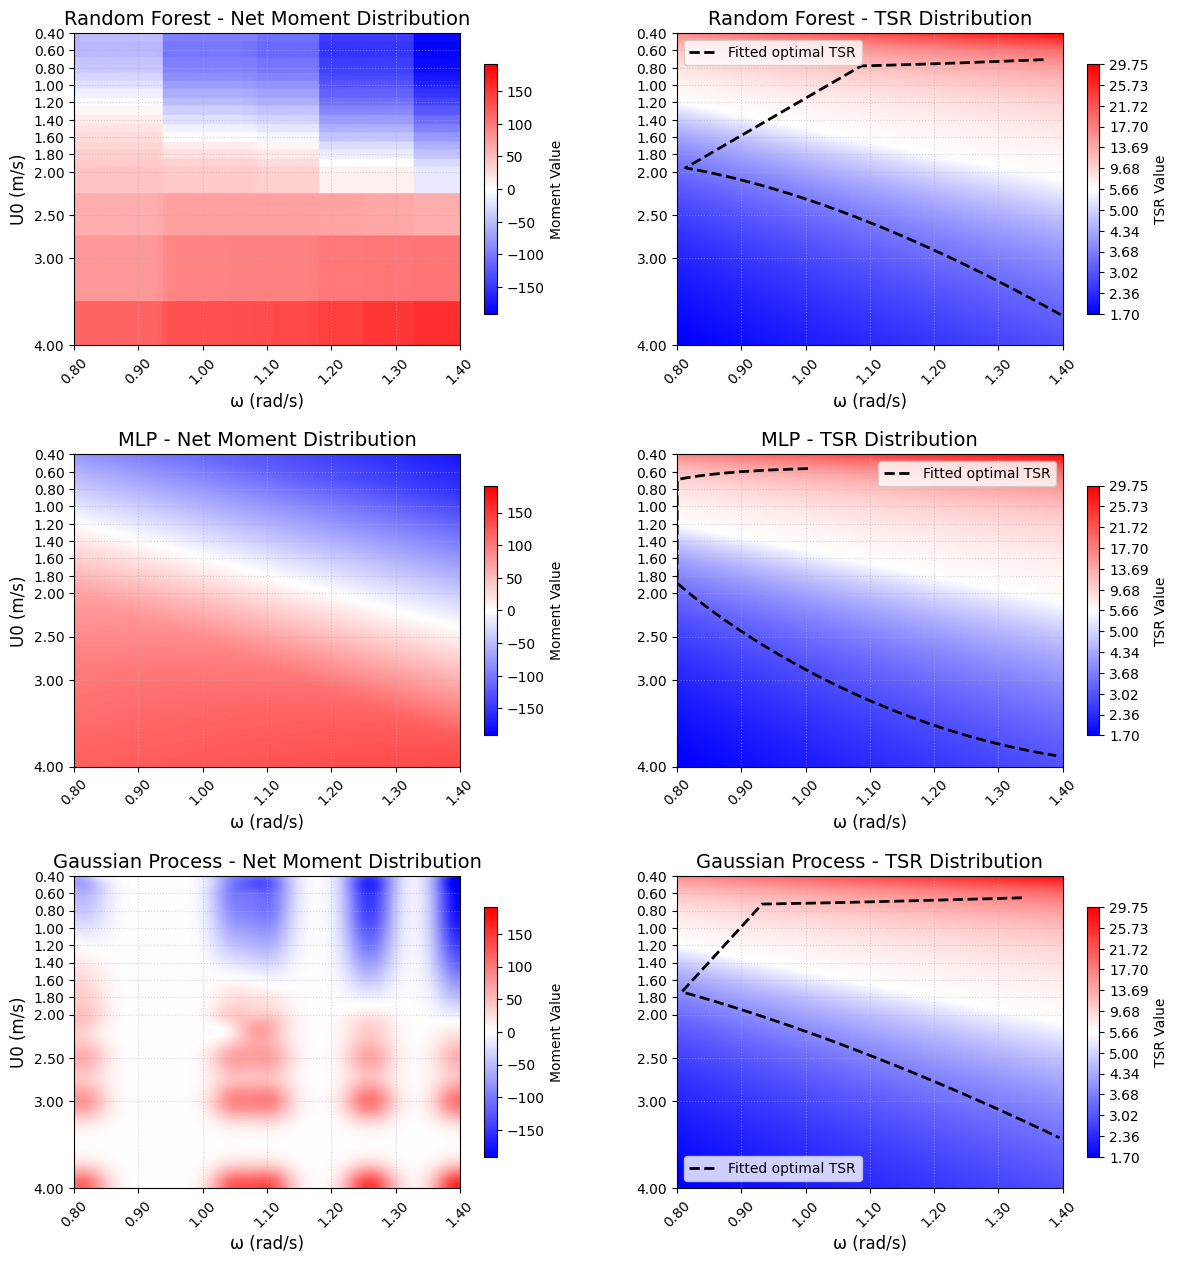

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

# 1. Define data
R = 8.5  # Rotor radius
U0_list = np.array([0.400, 0.600, 0.756, 0.800, 0.810, 0.900, 1.000, 1.100, 1.200, 1.300,
                    1.400, 1.500, 1.600, 1.700, 1.800, 1.900, 2.000, 2.500, 3.000, 4.000])
omega_list = np.array([0.800, 0.817, 1.055, 1.067, 1.100, 1.260, 1.400])

moment_matrix = np.array([
    [-60.98, -41.95, -92.01, -94.84, -102.69, -143.16, -182.06],
    [-53.71, -56.73, -104.13, -106.81, -114.30, -154.24, -191.21],
    [-42.25, -45.38, -95.08, -97.85, -105.60, -145.53, -184.44],
    [-38.79, -41.95, -92.01, -94.85, -102.69, -143.16, -182.06],
    [-37.90, -41.05, -91.21, -94.02, -101.89, -142.51, -181.42],
    [-29.40, -32.52, -83.32, -86.21, -94.21, -135.74, -175.57],
    [-19.46, -22.47, -73.03, -75.93, -84.03, -126.38, -167.22],
    [ -9.88, -12.52, -61.37, -64.29, -72.48, -115.37, -156.86],
    [ -0.15,  -2.83, -48.74, -51.61, -59.72, -102.88, -144.96],
    [  8.77,   6.79, -35.68, -38.41, -46.28, -88.99, -131.43],
    [ 15.85,  13.64, -22.63, -25.12, -32.57, -74.07, -116.54],
    [ 22.31,  21.21, -10.31, -12.94, -19.19, -58.62, -100.43],
    [ 27.50,  26.89,   1.91,   0.67,  -6.65, -42.87, -83.52],
    [ 32.33,  32.01,  13.98,  12.68,   5.59, -27.52, -66.25],
    [ 36.73,  36.67,  22.87,  22.47,  18.38, -12.79, -48.82],
    [ 40.79,  40.93,  32.97,  31.92,  26.51,   1.30, -31.63],
    [ 44.31,  44.72,  40.88,  40.30,  37.84,  17.07, -15.18],
    [ 58.45,  59.67,  71.17,  71.33,  71.58,  68.03,  57.29],
    [ 74.19,  75.03,  92.41,  93.31,  95.52, 102.40, 102.86],
    [112.11, 113.43, 131.28, 132.22, 134.54, 148.75, 164.40]
])

# 2. Data preprocessing
X_train = np.column_stack((np.repeat(U0_list, len(omega_list)),
                         np.tile(omega_list, len(U0_list))))
y_train = moment_matrix.ravel()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 3. Train models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "MLP": MLPRegressor(hidden_layer_sizes=(100,50), max_iter=10000,
                       random_state=42, early_stopping=True),
    "Gaussian Process": GaussianProcessRegressor(
        kernel=C(1.0) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e3)),
        random_state=42, n_restarts_optimizer=10, optimizer='fmin_l_bfgs_b')
}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)

# 4. Create prediction mesh
U0_dense = np.linspace(U0_list.min(), U0_list.max(), 200)
omega_dense = np.linspace(omega_list.min(), omega_list.max(), 200)
U0_mesh, omega_mesh = np.meshgrid(U0_dense, omega_dense, indexing='ij')
X_dense = np.column_stack((U0_mesh.ravel(), omega_mesh.ravel()))
X_dense_scaled = scaler.transform(X_dense)

moment_preds = {
    name: model.predict(X_dense_scaled).reshape(U0_mesh.shape)
    for name, model in models.items()
}

# 5. Plot settings
max_moment = np.max(np.abs(moment_matrix))
norm_moment = TwoSlopeNorm(vmin=-max_moment, vcenter=0, vmax=max_moment)
cmap_moment = LinearSegmentedColormap.from_list("custom_coolwarm", ["blue", "white", "red"])
TSR_values = (omega_mesh * R) / U0_mesh
TSR_min, TSR_max = np.nanmin(TSR_values), np.nanmax(TSR_values)
TSR_mid = 5.66
cmap_TSR = LinearSegmentedColormap.from_list("custom_TSR", ["blue", "white", "red"])

# 6. Final plotting function
def create_final_plots():
    plt.style.use('default')
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.grid': True,
        'grid.linestyle': ':',
        'grid.alpha': 0.5
    })

    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    plt.subplots_adjust(hspace=0.35, wspace=0.25)

    omega_ticks = np.round(np.arange(0.8, 1.41, 0.1), 2)
    U0_ticks = np.concatenate([
        np.round(np.arange(0.4, 2.1, 0.2), 2),
        [2.5, 3.0, 4.0]
    ])

    for idx, (name, moment_pred) in enumerate(moment_preds.items()):
        TSR_pred = (omega_mesh * R) / U0_mesh

        ax1 = axes[idx, 0]
        im1 = ax1.imshow(moment_pred, cmap=cmap_moment, norm=norm_moment,
                         extent=[omega_ticks[0], omega_ticks[-1],
                                 U0_list.max(), U0_list.min()],
                         aspect="auto", origin='upper')
        ax1.set_xticks(omega_ticks)
        ax1.set_xticklabels([f"{w:.2f}" for w in omega_ticks], rotation=45)
        ax1.set_yticks(U0_ticks)
        ax1.set_yticklabels([f"{u:.2f}" for u in U0_ticks])
        ax1.set_xlabel("ω (rad/s)", fontsize=12)
        ax1.set_ylabel("U0 (m/s)", fontsize=12)
        ax1.set_title(f"{name} - Net Moment Distribution", fontsize=14)
        ax1.set_facecolor('#f8f8f8')
        cbar1 = fig.colorbar(im1, ax=ax1, shrink=0.8)
        cbar1.set_label("Moment Value", fontsize=10)

        ax2 = axes[idx, 1]
        norm_TSR = TwoSlopeNorm(vmin=TSR_min, vcenter=TSR_mid, vmax=TSR_max)
        im2 = ax2.imshow(TSR_pred, cmap=cmap_TSR, norm=norm_TSR,
                         extent=[omega_ticks[0], omega_ticks[-1],
                                 U0_list.max(), U0_list.min()],
                         aspect="auto", origin='upper')
        ax2.set_xticks(omega_ticks)
        ax2.set_xticklabels([f"{w:.2f}" for w in omega_ticks], rotation=45)
        ax2.set_yticks(U0_ticks)
        ax2.set_yticklabels([f"{u:.2f}" for u in U0_ticks])
        ax2.set_xlabel("ω (rad/s)", fontsize=12)
        ax2.set_title(f"{name} - TSR Distribution", fontsize=14)
        ax2.set_facecolor('#f8f8f8')
        cbar2 = fig.colorbar(im2, ax=ax2, shrink=0.8)
        cbar2.set_label("TSR Value", fontsize=10)
        num_ticks = 6
        lower_ticks = np.linspace(TSR_min, TSR_mid, num_ticks+1)[:-1]
        upper_ticks = np.linspace(TSR_mid, TSR_max, num_ticks+1)[1:]
        ticks = np.concatenate([lower_ticks, [TSR_mid], upper_ticks])
        cbar2.set_ticks(ticks)
        cbar2.set_ticklabels([f"{t:.2f}" for t in ticks])

        # Optimal TSR fit
        optimal_omega_indices = np.argmax(moment_pred, axis=1)
        optimal_omega = omega_dense[optimal_omega_indices]
        optimal_U0 = U0_dense.copy()

        valid_mask = (optimal_omega >= omega_dense.min()) & (optimal_omega <= omega_dense.max())
        optimal_U0 = optimal_U0[valid_mask]
        optimal_omega = optimal_omega[valid_mask]

        if len(optimal_U0) == 0:
            continue

        X_fit = np.column_stack([optimal_U0, optimal_omega**2, optimal_omega, np.ones_like(optimal_U0)])
        y_fit = (optimal_omega * R) / optimal_U0

        reg = LinearRegression().fit(X_fit, y_fit)
        a, b, c, d = reg.coef_[0], reg.coef_[1], reg.coef_[2], reg.intercept_

        omega_fit, U0_fit = [], []
        for u0 in U0_dense:
            A = b
            B = c - R / u0
            C = a * u0 + d
            if A == 0:
                if B == 0:
                    continue
                omega = -C / B
            else:
                discriminant = B**2 - 4*A*C
                if discriminant < 0:
                    continue
                sqrt_discriminant = np.sqrt(discriminant)
                omega1 = (-B + sqrt_discriminant) / (2*A)
                omega2 = (-B - sqrt_discriminant) / (2*A)
                valid_omegas = [omega for omega in [omega1, omega2] if omega_dense.min() <= omega <= omega_dense.max()]
                if not valid_omegas:
                    continue
                omega_fit.append(valid_omegas[0])
                U0_fit.append(u0)

        if omega_fit and U0_fit:
            ax2.plot(omega_fit, U0_fit, 'k--', linewidth=2, label='Fitted optimal TSR')
            ax2.legend()

    plt.show()

# Call the plotting function
create_final_plots()